In [1]:
#Importando bibliotecas e frameworks

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras

import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

In [2]:
#Importando os datasets

diretorio_treino ='./Dataset/Train'
diretorio_teste = './Dataset/Test'

tam_imagem = (224, 224)
batch_size = 128

ds_treino = tf.keras.utils.image_dataset_from_directory(
    diretorio_treino,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size= tam_imagem,
    shuffle=True
)

ds_teste = tf.keras.utils.image_dataset_from_directory(
    diretorio_teste,
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size= tam_imagem,
    shuffle=True
)

num_classes = len(ds_treino.class_names)

data_augmentation = tf.keras.models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

def augment_images(images, labels):
    return data_augmentation(images, training=True), labels

#Novo dataset já com data augmentation

ds_treino_aug = ds_treino.map(
    augment_images,
    num_parallel_calls=tf.data.AUTOTUNE
)

Found 329 files belonging to 2 classes.
Found 110 files belonging to 2 classes.


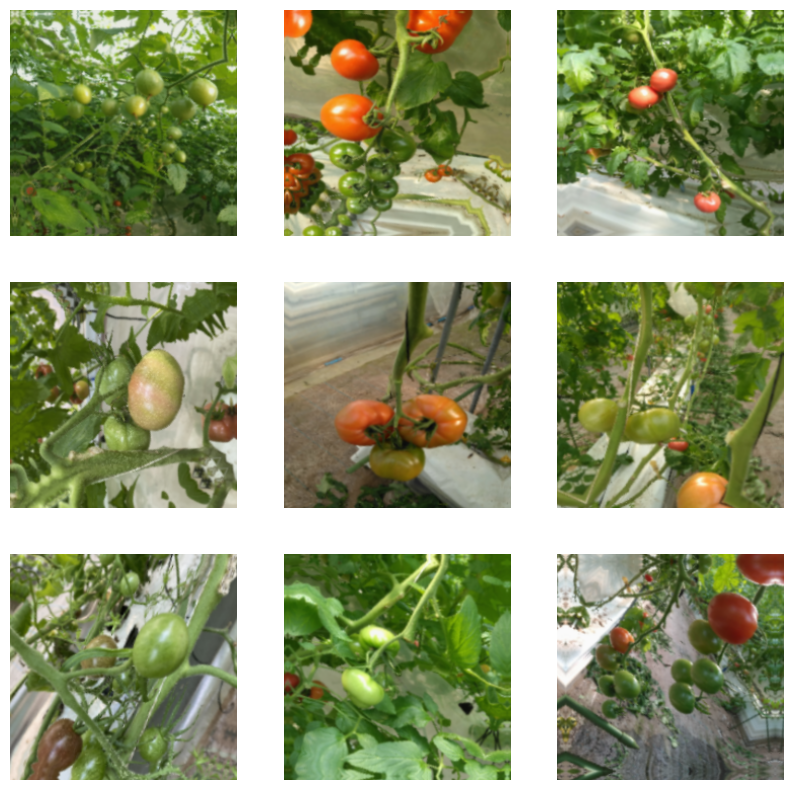

In [3]:
#Extraindo exemplos de imagens com data augmentation

for images, _ in ds_treino_aug.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
      image_expanded = tf.expand_dims(images[i], 0)
      augmented_image = data_augmentation(image_expanded, training=True)
      augmented_image = tf.squeeze(augmented_image, 0)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(augmented_image.numpy().astype("uint8"))
      plt.axis("off")
    plt.show()

In [4]:
#Construindo uma rede neural do zero

model_scratch = keras.Sequential()

print("Input dimensions after preprocessing: ",ds_treino_aug.element_spec[0].shape)

model_scratch.add(keras.Input(shape=(224, 224, 3)))

model_scratch.add(layers.Conv2D(32, (3, 3)))
model_scratch.add(layers.Activation('relu'))
model_scratch.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(layers.Conv2D(32, (3, 3)))
model_scratch.add(layers.Activation('relu'))
model_scratch.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(layers.Dropout(0.25))

model_scratch.add(layers.Conv2D(32, (3, 3)))
model_scratch.add(layers.Activation('relu'))
model_scratch.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(layers.Conv2D(32, (3, 3)))
model_scratch.add(layers.Activation('relu'))
model_scratch.add(layers.MaxPooling2D(pool_size=(2, 2)))

model_scratch.add(layers.Dropout(0.25))

model_scratch.add(layers.Flatten())
model_scratch.add(layers.Dense(256))
model_scratch.add(layers.Activation('relu'))

model_scratch.add(layers.Dropout(0.5))

model_scratch.add(layers.Dense(ds_treino_aug.element_spec[1].shape[1]))
model_scratch.add(layers.Activation('softmax'))

model_scratch.summary()

Input dimensions after preprocessing:  (None, 224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0     

In [5]:
#Compilando o modelo

model_scratch.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model_scratch.fit(ds_treino_aug,
                    validation_data=ds_teste,
                    batch_size = 128,
                    epochs=20,
)

Epoch 1/20
3/3 [==============================] - 8s 823ms/step - loss: 87.6493 - accuracy: 0.5198 - val_loss: 47.1210 - val_accuracy: 0.5000
Epoch 2/20
3/3 [==============================] - 4s 404ms/step - loss: 39.1570 - accuracy: 0.5289 - val_loss: 4.7966 - val_accuracy: 0.5000
Epoch 3/20
3/3 [==============================] - 4s 425ms/step - loss: 5.3449 - accuracy: 0.4498 - val_loss: 0.7197 - val_accuracy: 0.5455
Epoch 4/20
3/3 [==============================] - 4s 400ms/step - loss: 1.7138 - accuracy: 0.5228 - val_loss: 1.1481 - val_accuracy: 0.5182
Epoch 5/20
3/3 [==============================] - 4s 442ms/step - loss: 1.3053 - accuracy: 0.5076 - val_loss: 0.7671 - val_accuracy: 0.4909
Epoch 6/20
3/3 [==============================] - 4s 448ms/step - loss: 0.9194 - accuracy: 0.5502 - val_loss: 0.7787 - val_accuracy: 0.5000
Epoch 7/20
3/3 [==============================] - 4s 396ms/step - loss: 0.7763 - accuracy: 0.5076 - val_loss: 0.7324 - val_accuracy: 0.5000
Epoch 8/20
3/3 [=

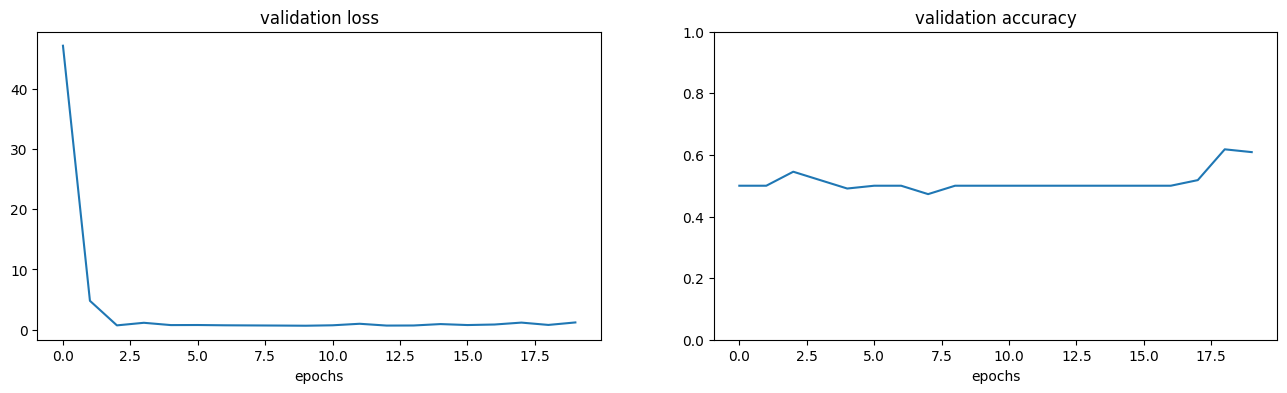

In [6]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [7]:
test_loss, test_accuracy = model_scratch.evaluate(ds_teste, verbose=0)
print('Test loss:', test_loss)
print('Test accuracy:', test_accuracy)

Test loss: 1.2055940628051758
Test accuracy: 0.6090909242630005


In [8]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [9]:
#Fiz uma referência para o input da VGG16

inputs = vgg.input

#Criei uma nova camada de saída com 2 neurônios (meu número de classes)

new_classification_layer = Dense(num_classes, activation='softmax')

outputs = new_classification_layer(vgg.layers[-2].output)

#Criei uma nova rede

model_new = models.Model(inputs, outputs)

In [10]:
# Congelei todas as camadas ao congelar os seus pesos (execeto a camada de saída)

for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

#Granti que a última rede é treinável (não congelada)

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [11]:
history2 = model_new.fit(ds_treino_aug,
                    validation_data=ds_teste,
                    batch_size=128,
                    epochs=20,
)

Epoch 1/20
3/3 [==============================] - 12s 3s/step - loss: 0.8444 - accuracy: 0.6261 - val_loss: 0.5945 - val_accuracy: 0.8273
Epoch 2/20
3/3 [==============================] - 4s 621ms/step - loss: 0.4986 - accuracy: 0.7812 - val_loss: 0.6204 - val_accuracy: 0.8273
Epoch 3/20
3/3 [==============================] - 4s 629ms/step - loss: 0.4400 - accuracy: 0.8146 - val_loss: 0.7063 - val_accuracy: 0.8091
Epoch 4/20
3/3 [==============================] - 4s 612ms/step - loss: 0.4327 - accuracy: 0.8237 - val_loss: 0.7453 - val_accuracy: 0.8364
Epoch 5/20
3/3 [==============================] - 4s 614ms/step - loss: 0.3852 - accuracy: 0.8359 - val_loss: 0.5578 - val_accuracy: 0.8182
Epoch 6/20
3/3 [==============================] - 4s 609ms/step - loss: 0.3582 - accuracy: 0.8571 - val_loss: 0.5741 - val_accuracy: 0.8273
Epoch 7/20
3/3 [==============================] - 4s 609ms/step - loss: 0.2549 - accuracy: 0.8997 - val_loss: 0.5883 - val_accuracy: 0.8273
Epoch 8/20
3/3 [======

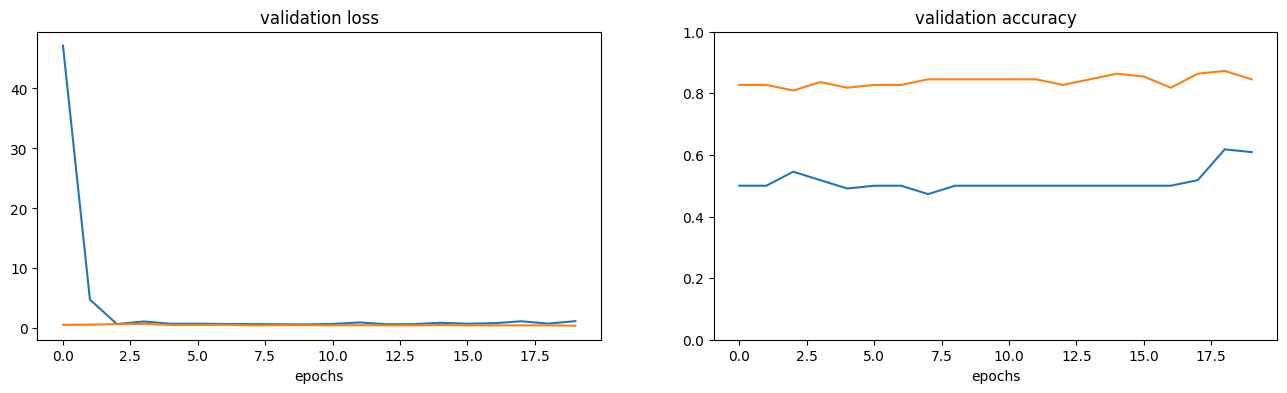

In [12]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()